<a href="https://colab.research.google.com/github/taddbackus/CaseStudy2DDS/blob/main/Lab%202/Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ConfusionMatrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from google.colab import files

In [4]:
files.upload()
# read the files into a dataframe
forest_cover_type = pd.read_csv('covtype.csv') 

# verify the dataframe loaded
print(forest_cover_type.shape)
forest_cover_type.head()


(581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


# Data Preparation Part 1

In [5]:
# Data clean-up
# make list of continuous variables
continuous_variables = ['Elevation', 
                        'Aspect', 
                        'Slope', 
                        'Horizontal_Distance_To_Hydrology', 
                        'Vertical_Distance_To_Hydrology',
                        'Horizontal_Distance_To_Roadways',
                        'Hillshade_9am','Hillshade_Noon',
                        'Hillshade_3pm',
                        'Horizontal_Distance_To_Fire_Points']

# use list to make df
continuous_variables_df = forest_cover_type[continuous_variables]

# subset df to make binary categorical
# second number not inclusive
Wilderness_Area = forest_cover_type.iloc[:, 10:14]
Wilderness_Area['Wilderness_Area'] = Wilderness_Area.idxmax(axis = 1)

# subset df to make binary categorical
# second number not inclusive
Soil_Type = forest_cover_type.iloc[:, 14:54]
Soil_Type['Soil_Type'] = Soil_Type.idxmax(axis = 1)

# only keep the new column
Soil_Type = Soil_Type[['Soil_Type']]
Wilderness_Area = Wilderness_Area[['Wilderness_Area']]

# Add new columns to df
forest_cover_type['Soil_Type'] = Soil_Type
forest_cover_type['Wilderness_Area'] = Wilderness_Area

# delete first few characters in column so we only have number
forest_cover_type['Soil_Type'] = forest_cover_type['Soil_Type'].str[9:]
forest_cover_type['Wilderness_Area'] = forest_cover_type['Wilderness_Area'].str[15:]


# delete superfluous columns now that new columns are added
forest_cover_type.drop(forest_cover_type.iloc[:, 10:54], 
                       axis = 1, 
                       inplace = True)



In [6]:
# Convert to category data type
forest_cover_type['Cover_Type'] = forest_cover_type['Cover_Type'].astype('category')
forest_cover_type['Soil_Type'] = forest_cover_type['Soil_Type'].astype('category')
forest_cover_type['Wilderness_Area'] = forest_cover_type['Wilderness_Area'].astype('category')

In [7]:
# Check the data types
forest_cover_type.dtypes

Elevation                                int64
Aspect                                   int64
Slope                                    int64
Horizontal_Distance_To_Hydrology         int64
Vertical_Distance_To_Hydrology           int64
Horizontal_Distance_To_Roadways          int64
Hillshade_9am                            int64
Hillshade_Noon                           int64
Hillshade_3pm                            int64
Horizontal_Distance_To_Fire_Points       int64
Cover_Type                            category
Soil_Type                             category
Wilderness_Area                       category
dtype: object

In [8]:
forest_cover_type

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type,Wilderness_Area
0,2596,51,3,258,0,510,221,232,148,6279,5,29,1
1,2590,56,2,212,-6,390,220,235,151,6225,5,29,1
2,2804,139,9,268,65,3180,234,238,135,6121,2,12,1
3,2785,155,18,242,118,3090,238,238,122,6211,2,30,1
4,2595,45,2,153,-1,391,220,234,150,6172,5,29,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,3,2,3
581008,2391,152,19,67,12,95,240,237,119,845,3,2,3
581009,2386,159,17,60,7,90,236,241,130,854,3,2,3
581010,2384,170,15,60,5,90,230,245,143,864,3,2,3


In [9]:
forest_cover_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   Elevation                           581012 non-null  int64   
 1   Aspect                              581012 non-null  int64   
 2   Slope                               581012 non-null  int64   
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64   
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64   
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64   
 6   Hillshade_9am                       581012 non-null  int64   
 7   Hillshade_Noon                      581012 non-null  int64   
 8   Hillshade_3pm                       581012 non-null  int64   
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64   
 10  Cover_Type                          581012 non-null  category
 11  Soil_Type    

## Data Meaning 

Attributes:	

- 10 quantitative variables
  - Elevation - Elevation in meters
  - Aspect - Aspect in degrees azimuth
  - Slope - Slope in degrees
  - Horizontal Distance to Hydrology - Horz Dist to nearest surface water features (meters)
  - Vertical Distance to Hydrology - Vert Dist to nearest surface water features (meters)
  - Horizontal Distance to Roadways - Horz Dist to nearest roadway (meters)
  - Hill shade 9 am (0 to 255 index) - Hillshade index at 9am, summer solstice
  - Hill shade noon (0 to 255 index) - Hillshade index at noon, summer solstice
  - Hill shade 3 pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
  - Horizontal distance to fire points - Horz Dist to nearest wildfire ignition points (meters)


- 3 Categorical variables
	- Wilderness area
  - 1: Neota
  - 2: Rawah
  - 3: Comanche Peak
  - 4: Cache la Poudre
	- Cover Type
  - 1: Spruce/Fir
  - 2: Lodgepole Pine
  - 3: Ponderosa Pine
  - 4: Cottonwood/Willow
  - 5: Aspen
  - 6: Douglas-fir
  - 7: Krummholz
	- Soil Type
		- 1: Cathedral family - Rock outcrop complex, extremely stony.
		- 2: Vanet - Ratake families complex, very stony.
		- 3: Haploborolis - Rock outcrop complex, rubbly.
		- 4: Ratake family - Rock outcrop complex, rubbly.
		- 5: Vanet family - Rock outcrop complex complex, rubbly.
		- 6: Vanet - Wetmore families - Rock outcrop complex, stony.
		- 7: Gothic family.
		- 8: Supervisor - Limber families complex.
		- 9: Troutville family, very stony.
		- 10: Bullwark - Catamount families - Rock outcrop complex, rubbly.
		- 11: Bullwark - Catamount families - Rock land complex, rubbly.
		- 12: Legault family - Rock land complex, stony.
		- 13: Catamount family - Rock land - Bullwark family complex, rubbly.
		- 14: Pachic Argiborolis - Aquolis complex.
		- 15: unspecified in the USFS Soil and ELU Survey.
		- 16: Cryaquolis - Cryoborolis complex.
		- 17: Gateview family - Cryaquolis complex.
		- 18: Rogert family, very stony.
		- 19: Typic Cryaquolis - Borohemists complex.
		- 20: Typic Cryaquepts - Typic Cryaquolls complex.
		- 21: Typic Cryaquolls - Leighcan family, till substratum complex.
		- 22: Leighcan family, till substratum, extremely bouldery.
		- 23: Leighcan family, till substratum - Typic Cryaquolls complex.
		- 24: Leighcan family, extremely stony.
		- 25: Leighcan family, warm, extremely stony.
		- 26: Granile - Catamount families complex, very stony.
		- 27: Leighcan family, warm - Rock outcrop complex, extremely stony.
		- 28: Leighcan family - Rock outcrop complex, extremely stony.
		- 29: Como - Legault families complex, extremely stony.
		- 30: Como family - Rock land - Legault family complex, extremely stony.
		- 31: Leighcan - Catamount families complex, extremely stony.
		- 32: Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
		- 33: Leighcan - Catamount families - Rock outcrop complex, extremely stony.
		- 34: Cryorthents - Rock land complex, extremely stony.
		- 35: Cryumbrepts - Rock outcrop - Cryaquepts complex.
		- 36: Bross family - Rock land - Cryumbrepts complex, extremely stony.
		- 37: Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
		- 38: Leighcan - Moran families - Cryaquolls complex, extremely stony.
		- 39: Moran family - Cryorthents - Leighcan family complex, extremely stony.
		- 40: Moran family - Cryorthents - Rock land complex, extremely stony.	
	

---
# Data Preparation Part 2

We brought our original data down from 55 columns down to 13. This will, not only make it easier to view and understand the data, but also allow the machine to run the models we will create. 

We converted the following features into categorical features: Wilderness Area, Cover Type, Soil Type. The Soil Type feature was initially was spread out in binary columns for each type (40 of them). Wilderness Area was also like this, but just with less columns. Once combined into one column, the binary features were converted into categorical. 

The remaining 10 features are integer data types. The measurements used for these 10 features have no decimal point, so no need to convert to float. They have remained as an integer.

Using multiple continuous variables will help us create regression models, whereas having a few categorical features will allow for classification models. 



---
# Modeling and Evaluation 1

We will look at a variety of different metrics. We will look at accuracy first. We do this to get a general undersanding of the data models. We will look at other evaluation metrics due to accuracy being a good metric when the distributions are equal. Accuracy can be misleading becasue of the class distribution.

We will also measure the precision and recall for the models. These metrics  are good evaluation tools due to them taking into account both true positives and false positives/negatives. This allows for them being good despite the imbalnaced data. These two metrics are good indeicators but should still be looked at with caution. 

We will also look at the F1 score becasue of the caution that we place in the aforementioned metrics. F1 score is useful in imbalanced datasets because it takes into account both true positives and false positives/negatives. F1 score provides a trade-off between precision and recall; it is the harmonic mean of precision and recall.  

---
# Modeling and Evaluation 2	


We wanted to look at various splitting methods to measure various metrics for each one. We will start with test/train split.

We will use test/train due to its simpliity and ease of implementation. However, we also have slight cause for concern for thsi exact reason. It is a quick model splitting method.

We also will take a look at Cross Validation. This provides a more reliable estimate for model performance by averaging across folds. This is computationally expensive for large datasets like the one we have.

Finally, we will take a look at stratified cross validation. This will probably be the best one for our particular dataset because it ensures that the class proportions are maintained in each fold. This is good for imbalanced datasets like our own. 

##Need to adjust to include information on why we chose the method we did for this particular dataset.

---
# Modeling and Evaluation 3

### Random Forest

#### Test/Train Split

In [10]:
# Make target variable and data variable
y = forest_cover_type[['Cover_Type']]
X = forest_cover_type.loc[:, forest_cover_type.columns != 'Cover_Type']

In [11]:
# Takes about 2 min

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Create a random forest model
rfc = RandomForestClassifier(n_estimators = 100)

# Train the model on the training data
rfc.fit(X_train, y_train)

# Predict on the testing data
y_pred_rfc = rfc.predict(X_test)

# Calculate the accuracy of model
rfc_accuracy = accuracy_score(y_test, y_pred_rfc)

print('Accuracy:', rfc_accuracy) # 0.9625482990972695


Accuracy: 0.962832284880769


In [12]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           1       0.97      0.96      0.96     42557
           2       0.96      0.98      0.97     56500
           3       0.95      0.97      0.96      7121
           4       0.92      0.84      0.88       526
           5       0.94      0.81      0.87      1995
           6       0.95      0.92      0.93      3489
           7       0.98      0.96      0.97      4015

    accuracy                           0.96    116203
   macro avg       0.95      0.92      0.93    116203
weighted avg       0.96      0.96      0.96    116203



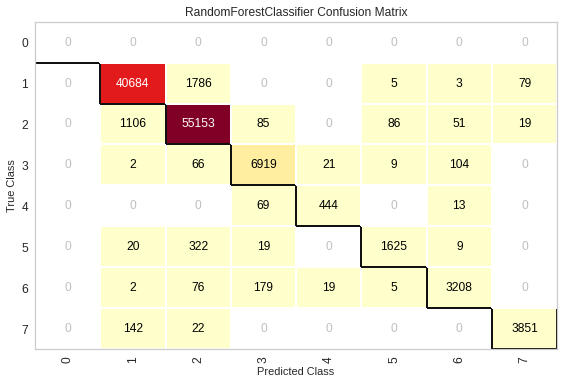

In [13]:
# Adapted from https://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(rfc, classes=[0, 1, 2, 3, 4, 5, 6, 7])

# Fit the model. 
cm.fit(X_train, y_train)

# Score runs predict() on the data and creates the confusion_matrix
cm.score(X_test, y_test)

cm.show();

#### Cross Validation

In [14]:
# takes about 25 min

# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators = 100)

cv = KFold(n_splits = 10, 
           shuffle = True, 
           random_state = 42)

accuracies = []
precisions = []
recalls = []
f1_scores = []

for train_idx, test_idx in cv.split(X, y):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rfc.fit(X_train, y_train)

    # Predict 
    y_pred_rfc = rfc.predict(X_test)

    # Calculate the accuracy, precision, recall and F1-score
    rfc_accuracy = accuracy_score(y_test, y_pred_rfc)
    rfc_precision = precision_score(y_test, y_pred_rfc, average = 'weighted')
    rfc_recall = recall_score(y_test, y_pred_rfc, average = 'weighted')
    rfc_f1 = f1_score(y_test, y_pred_rfc, average = 'weighted')

    # add to the lists
    accuracies.append(rfc_accuracy)
    precisions.append(rfc_precision)
    recalls.append(rfc_recall)
    f1_scores.append(rfc_f1)

    print('Accuracy:', rfc_accuracy)
    print('Precision:', rfc_precision)
    print('Recall:', rfc_recall)
    print('F1-score:', rfc_f1)
    print('\n')

# Print the mean 
print('\n')
print('Accuracy:', sum(accuracies) / len(accuracies))
print('Precision:', sum(precisions) / len(precisions))
print('Recall:', sum(recalls) / len(recalls))
print('F1-score:', sum(f1_scores) / len(f1_scores))

Accuracy: 0.9638910880864686
Precision: 0.9638783202308002
Recall: 0.9638910880864686
F1-score: 0.9637739054334752


Accuracy: 0.9654400881208909
Precision: 0.9654259759187812
Recall: 0.9654400881208909
F1-score: 0.9652761676626747


Accuracy: 0.9655599731502039
Precision: 0.9655267188754393
Recall: 0.9655599731502039
F1-score: 0.9654359596717076


Accuracy: 0.9668508287292817
Precision: 0.9668312632469431
Recall: 0.9668508287292817
F1-score: 0.9667339619380121


Accuracy: 0.9653706476652726
Precision: 0.9653641556189398
Recall: 0.9653706476652726
F1-score: 0.965255235550068


Accuracy: 0.9666270804289083
Precision: 0.9666523432177571
Recall: 0.9666270804289083
F1-score: 0.9664849852543387


Accuracy: 0.964234694755684
Precision: 0.9642254295342325
Recall: 0.964234694755684
F1-score: 0.9641176526878343


Accuracy: 0.9656460301888091
Precision: 0.9656473091163729
Recall: 0.9656460301888091
F1-score: 0.9655116244969119


Accuracy: 0.9669024629524449
Precision: 0.9669320695591829
Recall: 

**Cross Validation**

Mean Accuracy: 0.9656134497007921

Mean Precision: 0.9656145889819336

Mean Recall: 0.9656134497007921

Mean F1-score: 0.965490408727959

#### Stratified Cross Validation

In [16]:
# takes about 25 min

# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators = 100)

# Create a stratified 10-fold cross-validation 
cv = StratifiedKFold(n_splits = 10, 
                     shuffle = True, 
                     random_state = 42)

accuracies = []
precisions = []
recalls = []
f1_scores = []

for train_idx, test_idx in cv.split(X, y):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model
    rfc.fit(X_train, y_train)

    # Predict 
    y_pred_rfc = rfc.predict(X_test)

    # Calculate the accuracy, precision, recall and F1-score
    rfc_accuracy = accuracy_score(y_test, y_pred_rfc)
    rfc_precision = precision_score(y_test, y_pred_rfc, average = 'weighted')
    rfc_recall = recall_score(y_test, y_pred_rfc, average = 'weighted')
    rfc_f1 = f1_score(y_test, y_pred_rfc, average = 'weighted')

    # Append to the list
    accuracies.append(rfc_accuracy)
    precisions.append(rfc_precision)
    recalls.append(rfc_recall)
    f1_scores.append(rfc_f1)

# Print the scores
    print('Accuracy:', rfc_accuracy)
    print('Precision:', rfc_precision)
    print('Recall:', rfc_recall)
    print('F1-score:', rfc_f1)
    print('\n')

# Print the mean scores
print('\n')
print('Mean accuracy:', sum(accuracies) / len(accuracies))
print('Mean precision:', sum(precisions) / len(precisions))
print('Mean recall:', sum(recalls) / len(recalls))
print('Mean F1-score:', sum(f1_scores) / len(f1_scores))

Accuracy: 0.9655089325668652
Precision: 0.9655524911321326
Recall: 0.9655089325668652
F1-score: 0.9653574197196267


Accuracy: 0.9651991325599807
Precision: 0.9651696123663157
Recall: 0.9651991325599807
F1-score: 0.9650891868322923


Accuracy: 0.9653534362575515
Precision: 0.9653556838538084
Recall: 0.9653534362575515
F1-score: 0.9652270585139243


Accuracy: 0.966076315381835
Precision: 0.9660672398591607
Recall: 0.966076315381835
F1-score: 0.9659621156776287


Accuracy: 0.964183060532521
Precision: 0.9642084463690612
Recall: 0.964183060532521
F1-score: 0.9640285573753072


Accuracy: 0.9652157449957832
Precision: 0.9652167197962405
Recall: 0.9652157449957832
F1-score: 0.9650821312981248


Accuracy: 0.9646821913564311
Precision: 0.9646993670818754
Recall: 0.9646821913564311
F1-score: 0.9645664967725054


Accuracy: 0.9672639025145867
Precision: 0.9672103668530482
Recall: 0.9672639025145867
F1-score: 0.9671581304449424


Accuracy: 0.9667819830983976
Precision: 0.9667660072317438
Recall: 0

**Stratified Cross Validation**

Mean accuracy: 0.9655583699968281

Mean precision: 0.9655532905020234

Mean recall: 0.9655583699968281

Mean F1-score: 0.9654357962790965

### KNN

#### Test/Train Split

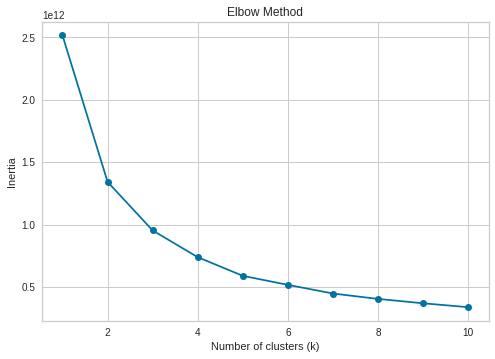

In [17]:
# Takes 2.5 min

# Try different values of k to find the elbow point
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker = 'o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

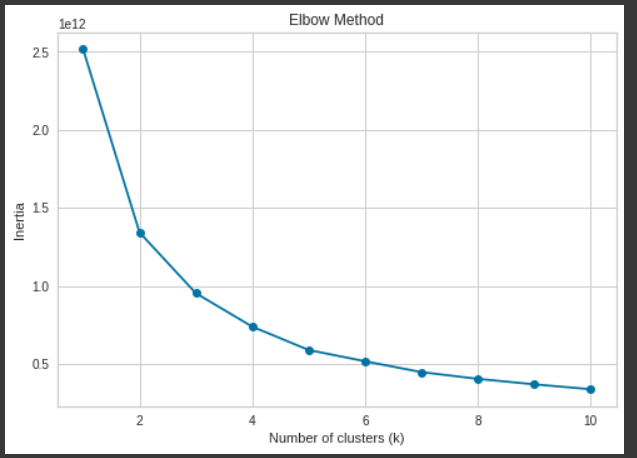

In [18]:
# Create a KNN classifier with k = 6
knn = KNeighborsClassifier(n_neighbors = 6)

# Train the model
knn.fit(X_train, y_train)

# Predict 
y_pred_knn = knn.predict(X_test)

# Calculate the metrics of the model
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_precision = precision_score(y_test, y_pred_knn, average = 'weighted')
knn_recall = recall_score(y_test, y_pred_knn, average = 'weighted')
knn_f1 = f1_score(y_test, y_pred_knn, average = 'weighted')

# Print metrucs
print('\n')
print('Accuracy:', knn_accuracy) 
print('Precision:', knn_precision)
print('Recall:', knn_recall)
print('F1-score:', knn_f1)



Accuracy: 0.9685547580936645
Precision: 0.9686905225021298
Recall: 0.9685547580936645
F1-score: 0.9684121945258358


Accuracy: 0.9685547580936645

Precision: 0.9686905225021298

Recall: 0.9685547580936645

F1-score: 0.9684121945258358

In [19]:
# print the metrics for each individual class
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           1       0.96      0.98      0.97     21184
           2       0.98      0.97      0.97     28330
           3       0.96      0.97      0.97      3575
           4       0.93      0.79      0.85       275
           5       0.97      0.83      0.89       949
           6       0.95      0.92      0.93      1737
           7       0.99      0.95      0.97      2051

    accuracy                           0.97     58101
   macro avg       0.96      0.91      0.94     58101
weighted avg       0.97      0.97      0.97     58101



#### Cross Validation

In [20]:
# Create a k-NN classifier
knn = KNeighborsClassifier(n_neighbors = 6)

# Evaluate the model using 10-fold cross validation
scores = cross_val_score(knn, 
                         X, 
                         y, 
                         cv = 10)


# Print the accuracy of each fold and the mean accuracy
print('\n')
print('Accuracy of each fold:', scores)
print('\n')
print('Mean accuracy:', scores.mean()) # Mean accuracy: 0.5362315601229429




Accuracy of each fold: [0.60906681 0.49218616 0.59344934 0.55694394 0.4901981  0.52844185
 0.53351922 0.50188465 0.4732965  0.58332903]


Mean accuracy: 0.5362315601229429


#### Stratified Cross Validation 

In [21]:
# Use stratified 10 fold cross validation to evaluate the model
cv = StratifiedKFold(n_splits = 10)
scores = cross_val_score(knn, 
                         X, 
                         y, 
                         cv = cv)

# Print the accuracy of each fold and the mean accuracy
print('\n')
print('Accuracy of each fold:', scores)
print('\n')
print('Mean accuracy:', scores.mean()) # 0.5362315601229429



Accuracy of each fold: [0.60906681 0.49218616 0.59344934 0.55694394 0.4901981  0.52844185
 0.53351922 0.50188465 0.4732965  0.58332903]


Mean accuracy: 0.5362315601229429


### Logistic Regression

#### Test/Train Split

In [22]:
# Create a logistic regression classifier
lr = LogisticRegression()

# Train the classifier on the training data
lr.fit(X_train, y_train)

# Predict the classes of the testing data
y_pred_lr = lr.predict(X_test)

# Calculate the accuracy of the classifier
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print('\n')
print('Accuracy:', lr_accuracy) # 0.6206949966437755
print('\n')

TypeError: ignored

In [ ]:
# print the metrics for each individual class
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           1       0.62      0.63      0.63     21422
           2       0.62      0.77      0.69     28128
           3       0.57      0.23      0.33      3603
           4       0.00      0.00      0.00       281
           5       0.00      0.00      0.00       894
           6       0.12      0.00      0.00      1744
           7       0.00      0.00      0.00      2029

    accuracy                           0.62     58101
   macro avg       0.28      0.23      0.24     58101
weighted avg       0.57      0.62      0.59     58101



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Cross Validation

In [23]:
# Perform 10-fold cross-validation and calculate the mean accuracy
cv_scores = cross_val_score(lr, X, y, cv = 10)
mean_accuracy = cv_scores.mean()

print('\n')
print('Cross-validation accuracy:', mean_accuracy) # 0.6009685968081737
print('\n')



Cross-validation accuracy: nan




Cross-validation accuracy: 0.6009685968081737


#### Stratified Cross Validation

In [24]:
# Create a stratified 10-fold cross-validator
skf = StratifiedKFold(n_splits = 10)

# Perform cross-validation
cv_scores = cross_val_score(lr, X, y, cv = skf)

# Calculate the mean accuracy of the cross-validation scores
mean_accuracy = cv_scores.mean()

print('\n')
print('Cross-validation accuracy:', mean_accuracy)
print('\n')



Cross-validation accuracy: nan




Cross-validation accuracy: 0.6009685968081737


### Regression Models for Elevation

Random Forest

In [ ]:
# Make target variable and data variable
y = forest_cover_type[['Elevation']]
X = forest_cover_type.loc[:, forest_cover_type.columns != 'Elevation']

In [ ]:
# Feature Importance Graph
# Takes about five minutes
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 50)
rf.fit(X, y)

<ipython-input-24-fbdec8dd1324>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X, y)


RandomForestRegressor(n_estimators=50)

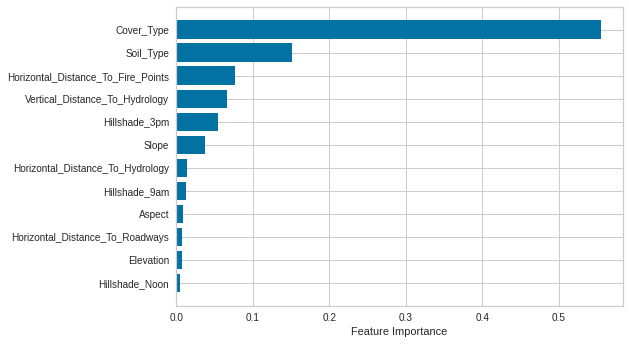

In [ ]:
sort = rf.feature_importances_.argsort()
plt.barh(forest_cover_type.columns.values[sort], rf.feature_importances_[sort])
plt.xlabel('Feature Importance')
plt.show()

In [ ]:
# Use stratified 10 fold cross validation to evaluate the model
cv = StratifiedKFold(n_splits = 10)
scores = cross_val_score(rf, 
                         X, 
                         y, 
                         cv = cv)

# Print the accuracy of each fold and the mean accuracy
print('\n')
print('Accuracy of each fold:', scores)
print('\n')
print('Mean accuracy:', scores.mean()) # 0.5362315601229429

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Accuracy of each fold: [0.96613317 0.97102462 0.96637699 0.96415034 0.96807074 0.97368821
 0.97228915 0.96826109 0.95145462 0.89730401]


Mean accuracy: 0.9598752946978163


In [ ]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

In [ ]:
scoresResults

In [ ]:
#gris search example for exceptional work
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = CappedLinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

NameError: ignored

---
# Modeling and Evaluation 4

Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.


In [ ]:
## This code block is temporary (printing for summary table below)

print ('accuracy for KNN classifier is :',knn_accuracy)
print ('accuracy for Random Forest classifier is :',rfc_accuracy)
print ('accuracy for Logistic Regression classifier is :',lr_accuracy)

print (knn_precision)
print (rfc_precision)

print (knn_recall)
print (rfc_recall)



accuracy for KNN classifier is : 0.9688301406172011
accuracy for Random Forest classifier is : 0.9645617115023838
accuracy for Logistic Regression classifier is : 0.6215211442143853
0.9689337839763762
0.9645981022236875
0.9688301406172011
0.9645617115023838


AUC and ROC Curves comparison of models - Cover Type


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


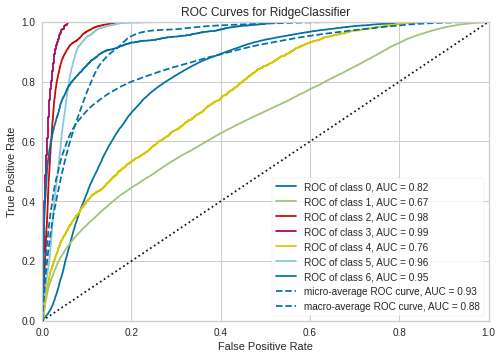

<AxesSubplot:title={'center':'ROC Curves for RidgeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
print ("AUC and ROC Curves comparison of models - Cover Type")
# from sklearn import metrics
# import matplotlib.pyplot as plt
# from sklearn import metrics as mt


# plt.figure()

# # Add the models to the list that you want to view on the ROC plot
# models = [
# {
#     'label': 'Random Forest Classifier',
#     'model': RandomForestClassifier(max_depth=5, n_estimators=10),
# },
# {
#     'label': 'KNN Classifier',
#     'model': KNeighborsClassifier(n_neighbors=6, weights='uniform', metric='euclidean'),
# },
# {
#     'label': 'Logistic Regression Classifier',
#     'model': LogisticRegression(),
# },
# ]

# # Below for loop iterates through your models list
# for m in models:
#     model = m['model'] # select the model
#     model.fit(X_train, y_train) # train the model
#     y_pred=model.predict(X_test) # predict the test data
# # Compute False postive rate, and True positive rate
#     fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# # Calculate Area under the curve to display on the plot
#     auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# # Now, plot the computed values
#     plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# # Custom settings for the plot 
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('Specificity(False Positive Rate)')
# plt.ylabel('Sensitivity(True Positive Rate)')
# plt.title('Receiver Operating Characteristic for Forest Cover Type')
# plt.legend(loc="lower right")
# plt.show()   # Actual plot


from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

from yellowbrick.classifier import ROCAUC

# Load multi-class classification dataset
cov = forest_cover_type

# Encode the non-numeric columns
X = OrdinalEncoder().fit_transform(X)
y = LabelEncoder().fit_transform(y)

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Instaniate the classification model and visualizer
model = RidgeClassifier()
visualizer = ROCAUC(model, classes=["0", "1", "2", "3", "4", "5", "6", "7"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure




For an ROC Curve, we would like to see a curve that goes up and across the most. Based on the ROC Curve for the forest cover type, we can see that it is relatively close between lodgepole pine (cover type 2) and ponderosa pine (cover type 3) with an AUC score of 0.98 and 0.99. Although, we can see that the class 3 curve has the highest peak.

The summary of the 3 tested models for forest cover type: 


Model               | Accuracy      | Precision | Recall | AUC
--------------------|---------------|-----------|--------|-----
Random Forest       | 0.9662        | 0.9662    | 0.9662 |
KNN                 | 0.9686        | 0.9687    | 0.9686 |
Logistic Regression | 0.6207        |           |        |

Overall, when comparing the three models to predict the forest cover type, the KNN model is slightly better than the Random Forest model in accuracy, precision, and recall. 

REPEAT FOR ELEVATION and then do a comparison for both tables.

In [ ]:
# from sklearn import metrics as mt

# print ("Confusion matrix for Random Forest Model - Cover Type:")
# cm = mt.confusion_matrix(y_test, rfc_accuracy)

# # cm = mt.confusion_matrix(y_test, y_pred)
# # plt.imshow(cm,cmap=plt.get_cmap('Reds'),aspect='auto')
# # plt.grid(False)



from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import classification_report

# Load the classification data set
# X, y = forest_cover_type()

# Specify the target classes
classes = ["Cover_Type", "Elevation"]

# Create the training and test data
tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Instantiate the visualizer
visualizer = classification_report(
    GaussianNB(), X_train, y_train, X_test, y_test, classes=classes, support=True
)

**NEED THIS TO BE LOOK AT ^**

--- 
# Modeling and Evaluation 5

Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.


**Accuracy Scores for various splitting methods vs models**

Splitting Method   | Random Forest | KNN    | Logistic
-------------------|---------------|--------|---------
Test/Train         | 0.9625        | 0.9658 | 0.6242
Cross Validation   | 0.9656        | 0.5362 | 0.6009
Stratified CV      | 0.9655        | 0.5362 | 0.6009


maybe include a table for other metrics

We looked at Train/Test Split to begin wih because it the most simplified and well-known form of data separation. We saw accuracy scores around 96% for Random Forest and kNN, but for Logistic Regression it dipped down to 62%. However, we have cause for concern with this method of splitting the data due to two of the Cover Types being highly skewed. Because of this, we looked at other data separation techniques. 

We use Stratified 10 Fold Cross Validation to help with the imbalanced dataset. This implements a fold in the data where each fold has the same ratio of instances of target variable as in the whole dataset. However, we saw a huge time increase in running this model. So something we have to consider is if the additional time is worth it? 

For our specific dataset, we saw about the same accuracy score. We had to look at some other performance metrics to gain a better understanding if the additional time is worth it. 

**NEED THIS TO BE LOOK AT ^**

---
# Modeling and Evaluation 6

#### Important features for classifying cover type




We looked at the feature importances from the random forest and logisitic regression models to investigate which attributes were the most important in classifying the cover type of a land plot

<BarContainer object of 12 artists>

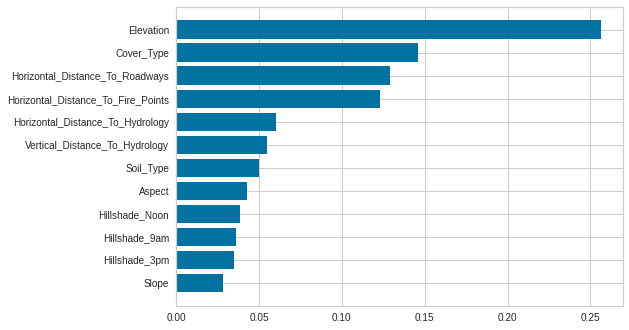

In [25]:
# Random Forest
rfFeatures = rfc.feature_importances_.argsort()
plt.barh(forest_cover_type.columns.values[rfFeatures],rfc.feature_importances_[rfFeatures])

<AxesSubplot:xlabel='Weight', ylabel='Var'>

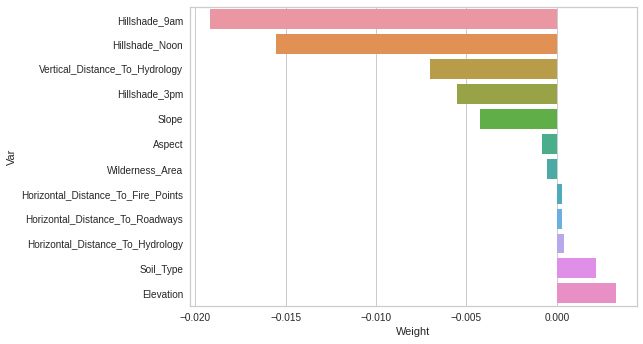

In [26]:
# Logistic Regression
lrWeights = pd.Series(lr.coef_[0],index=X.columns)
lrWeights = pd.DataFrame({'Var':lrWeights.index,'Weight':lrWeights.values})
lrWeights = lrWeights.sort_values('Weight')
sns.barplot(x='Weight',y='Var',data=lrWeights)

For the random forest classifier the most important attributes were elevation and horizontal distance to roadways and fire points. Distance to hydrology, soil type, aspect and hillshade were also somewhat important to the performance of the model.

For the logistic regression model hillshade and vertical distance to hydrology were the most important with slope, elevation, and soil type also being somewhat important. 

The most common attributes between the two models were elevation, distance to water, soil type, and hillshade or the amount of sun a plot of land receives throughout the day. These were likely important as all of these factors impact what types of trees grow and thrive in these conditions. Certain trees will favor different amounts of water and sunlight and may outperform other trees at higher elevations or in different types of soil.

#### Important features for predicting elevation

For performing regression on predicitng elevation we investigated the attribute importance from XXXX models.

---
# Deployment


The model we created could be used by various environmental agencies, logging companies, real estate companies, and government agencies to use readily available data to predict what types of trees or forest cover are in a plot of land without having to perform a expensive survey. This could impact analysis on the effects of deforestation, wildfires, and climate change, be used to choose appropriate places for logging or development, or track how protection policies are working. The model’s value could be measured by how likely it is to choose the correct class of cover type and at what resolution of plot size it could still perform well. The performance could also be evaluated by testing the model on similar data from a region near the Roosevelt National Forest but outside the range of the original data to test if performance is still adequate. The model could be deployed as a web based application that incorporates the GIS and land survey data used to train it to predict cover type of a user selected plot of land. However, with the current data used to train the model, only areas in Northern Colorado with similar geography and cover types could benefit from this model. Additional data could be collected to include more diverse landscapes with different cover types. Any additional data would require the model to be retrained to ensure the desired performance is met on different types of land and cover types. Data would need to be updated whenever new land areas are included, development or a natural disaster occurs, or yearly if no notable changes occur.

---
# Exceptinal Work
You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?


**NEED THIS TO BE LOOK AT ^**

Code below for ROC curve where multiclass is not supported.

In [ ]:


# from sklearn import metrics
# import matplotlib.pyplot as plt
# from sklearn import metrics as mt


# plt.figure()

# # Add the models to the list that you want to view on the ROC plot
# models = [
# {
#     'label': 'Random Forest Classifier',
#     'model': RandomForestClassifier(max_depth=5, n_estimators=10),
# },
# {
#     'label': 'KNN Classifier',
#     'model': KNeighborsClassifier(n_neighbors=6, weights='uniform', metric='euclidean'),
# },
# {
#     'label': 'Logistic Regression Classifier',
#     'model': LogisticRegression(),
# },
# ]

# # Below for loop iterates through your models list
# for m in models:
#     model = m['model'] # select the model
#     model.fit(X_train, y_train) # train the model
#     y_pred=model.predict(X_test) # predict the test data
# # Compute False postive rate, and True positive rate
#     fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# # Calculate Area under the curve to display on the plot
#     auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# # Now, plot the computed values
#     plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# # Custom settings for the plot 
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('Specificity(False Positive Rate)')
# plt.ylabel('Sensitivity(True Positive Rate)')
# plt.title('Receiver Operating Characteristic for Forest Cover Type')
# plt.legend(loc="lower right")
# plt.show()   # Actual plot

### SVM

takes too long

In [ ]:
from sklearn.svm import SVC

# Create an SVM classifier
svm = SVC(kernel='linear')

# Train the classifier on the training data
svm.fit(X_train, y_train)

# Predict the classes of the testing data
y_pred = svm.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV

# Create an SVM classifier
svm = LinearSVC()

# Define the hyperparameters to search over
parameters = {'C': [0.1, 1, 10, 100]}

# Create a grid search object to search over the hyperparameters
grid_search = GridSearchCV(svm, parameters, cv=5)

# Fit the grid search object on the training data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
svm = grid_search.best_estimator_

# Predict the classes of the testing data
y_pred = svm.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy)

### Testing out a pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


# Define the classifiers
svm = SVC(kernel='linear', C=1)
logistic = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

# Define the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', 'passthrough')
])

# Set up the hyperparameters to be tuned for each model
svm_params = {'classifier': [svm]}
logistic_params = {'classifier': [logistic]}
rfc_params = {'classifier': [rfc]}

# Add the parameter dictionaries to a list
params = [svm_params, logistic_params, rfc_params]


# Train the pipeline on the training data
pipe.fit(X_train, y_train)

# Predict the classes of the testing data using the pipeline
y_pred = pipe.predict(X_test)

# Calculate the accuracy of the pipeline
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy)

When the classes are imbalanced, the area under the Receiver Operating Characteristic (ROC) curve (AUC) is a useful evaluation metric. The ROC curve plots the true positive rate (sensitivity) against the false positive rate (1-specificity) at various thresholds. The AUC represents the probability that a randomly selected positive example will be ranked higher than a randomly selected negative example.